### IMPORTING DATASET

In [220]:
import pandas as pd
import numpy as np
import math
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns


In [221]:
# loading data-set

data = pd.read_csv(r"C:\Users\User\Desktop\Network-Intrusion-Detection\data\raw-data\Train_data.csv")
data2 = pd.read_csv(r"C:\Users\User\Desktop\Network-Intrusion-Detection\data\raw-data\Test_data.csv")

data.head(20)
data2.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


### Data preprocessing part 1

In [222]:
print("The row and columns of the dataset", data.shape)
print("the row and columns of the dataset2", data2.shape)

The row and columns of the dataset (25192, 42)
the row and columns of the dataset2 (22544, 41)


In [223]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [224]:
data.describe(include="object")

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


In [225]:
# checking for missing value

for col in data.columns:
    missing_value = data[col].isnull().sum()
    if missing_value > 0:
        print(f"{col}: {missing_value} missing values")
    else:
        print("There are no missing value")

There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
There are no missing value
T

In [226]:
print((data.isnull().sum()[lambda x: x > 0] / len(data) * 100)
      .round(3)
      .astype(str) + ' %')

missing_info = data.isnull().sum()
missing_info = missing_info[missing_info > 0].to_frame('Missing Count')
missing_info['Missing %'] = (missing_info['Missing Count'] / len(data) * 100).round(3)
print(missing_info)


Series([], dtype: object)
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


In [227]:
# check for duplicates

print(f"number of duplicated rows: {data.duplicated().sum()}")

number of duplicated rows: 0


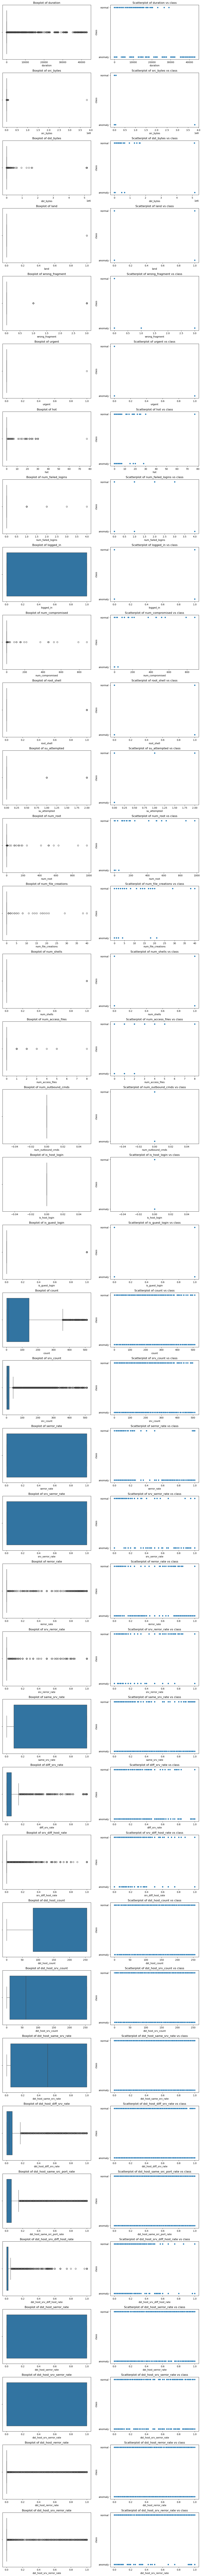

In [228]:
# outliers

# Filter numeric columns except 'class'
numeric_cols = [col for col in data.columns if col != 'class' and is_numeric_dtype(data[col])]

# Grid setup
n_cols = 2  # Boxplot + Scatterplot side by side for each feature
n_rows = len(numeric_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    # Boxplot
    sns.boxplot(x=data[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot of {col}")
    
    # Scatterplot vs class
    sns.scatterplot(data=data, x=data[col], y=data['class'], ax=axes[i, 1])
    axes[i, 1].set_title(f"Scatterplot of {col} vs class")

plt.tight_layout()
plt.show()


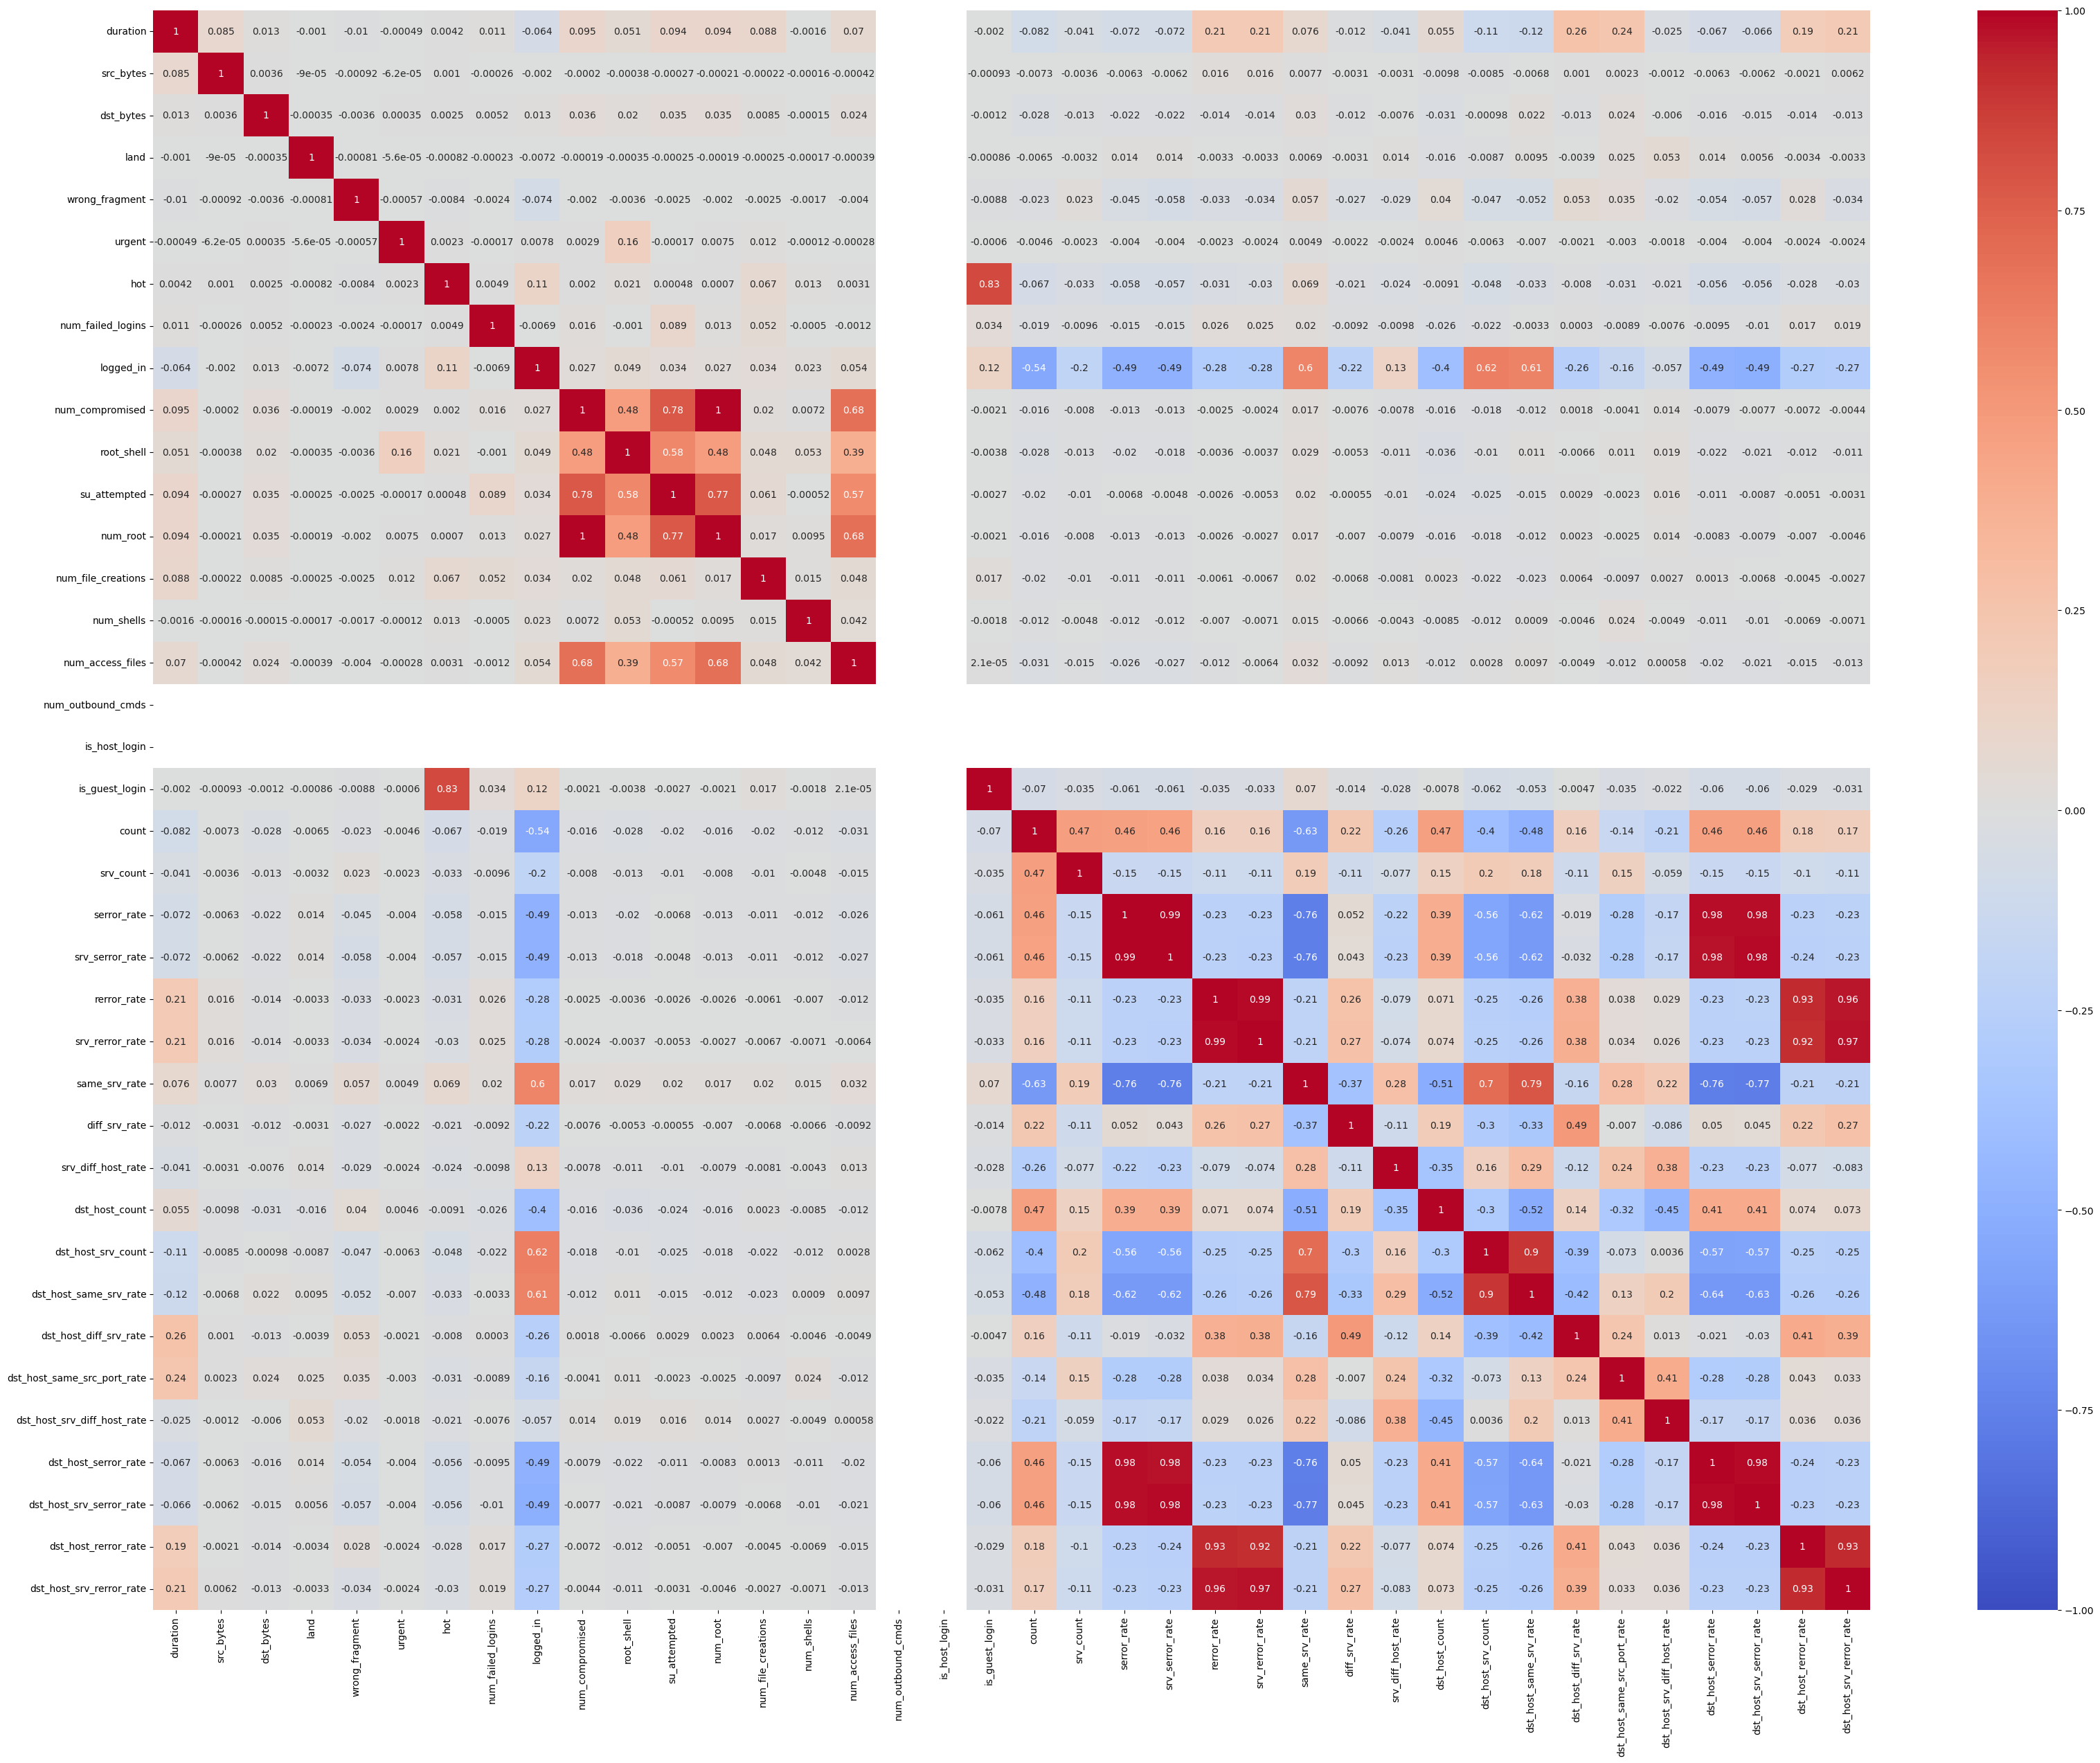

In [229]:
# Filter out only numeric columns for correlation calculation
numeric_train = data.select_dtypes(include=[np.number])

# Generate the heatmap
plt.figure(figsize=(40,30))
sns.heatmap(numeric_train.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [230]:
# this two columns are redundant

print(data["is_host_login"].value_counts())
print(data["num_outbound_cmds"].value_counts())

print(data2["is_host_login"].value_counts())
print(data2["num_outbound_cmds"].value_counts())

is_host_login
0    25192
Name: count, dtype: int64
num_outbound_cmds
0    25192
Name: count, dtype: int64
is_host_login
0    22533
1       11
Name: count, dtype: int64
num_outbound_cmds
0    22544
Name: count, dtype: int64


In [231]:
data.drop(["num_outbound_cmds"], axis=1, inplace=True)
data2.drop(["num_outbound_cmds"], axis=1, inplace=True)


In [232]:
data.drop(["is_host_login"], axis=1, inplace=True)
data2.drop(["is_host_login"], axis=1, inplace=True)

In [233]:
# checking attack class distributiion
print("value count for class",data["class"].value_counts())


value count for class class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [234]:
data.select_dtypes(include=["float64", "int64"]).columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'],
      dtype='object')

In [235]:
data.select_dtypes(include=["object"]).columns

Index(['protocol_type', 'service', 'flag', 'class'], dtype='object')

### Scaling Numerical Attribute

In [236]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# extract numerical attributes
cols = data.select_dtypes(include=['float64', 'int64']).columns

# Fit only on train
sc_data  = scaler.fit_transform(data[cols])

# Use the same scaler to transform test
sc_test = scaler.transform(data2[cols])

# turn the result back to dataframes
sc_traindf = pd.DataFrame(sc_data, columns=cols, index=data.index)
sc_testdf = pd.DataFrame(sc_test, columns=cols, index=data2.index)


### Encoding Categorical attribute


In [237]:
from sklearn.preprocessing import LabelEncoder

def encode_categoricals(train, test, target_col):
    encoders = {}

    # 1. Separate target column (only from train)
    y_train = train[target_col].copy()
    X_train = train.drop(columns=[target_col]).copy()
    X_test = test.copy()

    # 2. Encode only categorical (object) columns
    cat_cols = X_train.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))

        # Handle unseen categories in test → -1
        mapping = {cls: i for i, cls in enumerate(le.classes_)}
        X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)

        encoders[col] = le

    # Since test has no target_col
    y_test = None  

    return X_train, y_train, X_test, y_test, encoders
X_train, y_train, X_test, y_test, encoders = encode_categoricals(data, data2, target_col="class")
print("Shapes:", X_train.shape, y_train.shape, X_test.shape)




Shapes: (25192, 39) (25192,) (22544, 39)


In [238]:
X_test.shape

(22544, 39)

In [239]:
X_train.shape

(25192, 39)

In [240]:
# Convert rows to tuples for comparison
train_rows = set([tuple(row) for row in X_train.values])
test_rows = set([tuple(row) for row in X_test.values])

# Check intersection
overlap = train_rows.intersection(test_rows)

if len(overlap) > 0:
    print(f"⚠️ Found {len(overlap)} overlapping rows between train and test!")
else:
    print("✅ No overlap, train/test split is correct.")


⚠️ Found 117 overlapping rows between train and test!


### Using RandomForestClassifier for feature selection

In [241]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
raw_importances = rfc.feature_importances_
feature_importances = pd.DataFrame (
    {"feature": X_train.columns, "Importances": raw_importances}).sort_values(by="Importances", ascending=False)

# to display just the top 15 of the important features
feature_importances = feature_importances.head(15)
print(feature_importances)




                        feature  Importances
4                     src_bytes     0.177171
5                     dst_bytes     0.119239
26                same_srv_rate     0.087385
31       dst_host_same_srv_rate     0.069531
11                    logged_in     0.065261
3                          flag     0.063282
30           dst_host_srv_count     0.062195
20                        count     0.041072
1                 protocol_type     0.040321
27                diff_srv_rate     0.031740
36     dst_host_srv_serror_rate     0.028714
33  dst_host_same_src_port_rate     0.028082
2                       service     0.027425
32       dst_host_diff_srv_rate     0.025147
21                    srv_count     0.017362


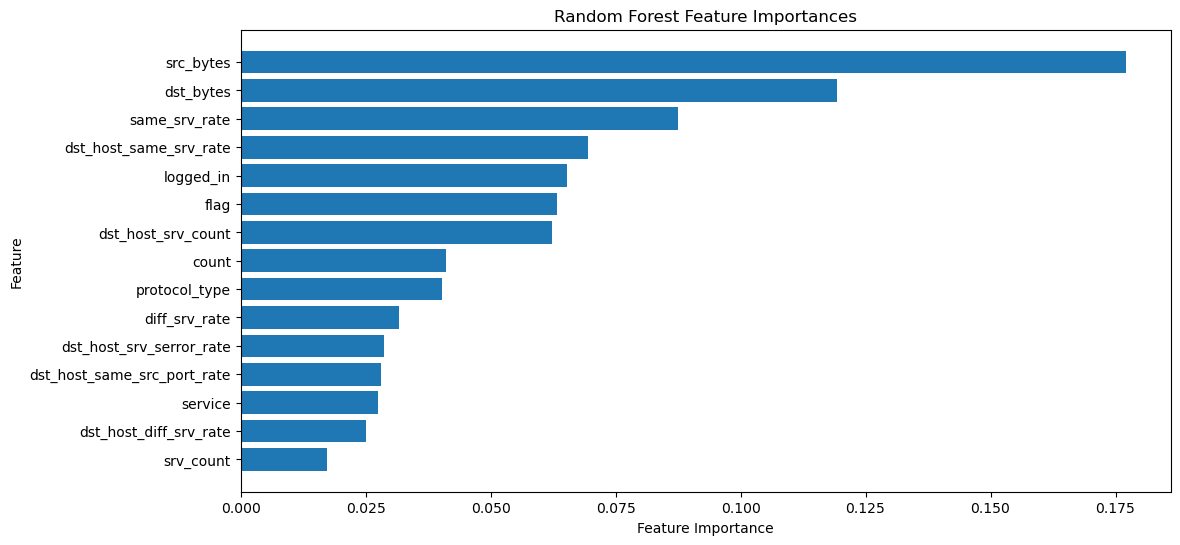

In [242]:
# plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importances["feature"], feature_importances["Importances"])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

### Using Recursive Feature Elimination (RFE) with Random Forest

In [243]:
from sklearn.feature_selection import RFE

# Base model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Select top 10 features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features.tolist())


Selected features: ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']


In [244]:
print(selected_features)

Index(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count',
       'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate'],
      dtype='object')


### split dataset, using only the selected features

In [245]:
from sklearn.model_selection import train_test_split
x_selected = X_train[selected_features]

X_train, X_test, y_train, y_test = train_test_split(x_selected, y_train, test_size=0.3, random_state=42, stratify=y_train)


### model training using randomforest classifier

In [248]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ----------predictions------------
y_pred = rf.predict(X_test)

# ---------- Evaluation --------------
print("Model trained with selected features")
print("Accuracy", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model trained with selected features
Accuracy 0.9964276263561789

Classification Report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      3523
      normal       1.00      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558


Confusion Matrix:
 [[3507   16]
 [  11 4024]]


### Hyperparameter tuning

In [ ]:
# we want to get the best hyperparameters for the model
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)


Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [250]:
# we have gotten the best hyperparameters for the model, we will use these parameters to train the models
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

best_rf.fit(X_train, y_train)



RandomForestClassifier(n_estimators=200, random_state=42)

In [251]:
# check the accuracy, precesion, recall, f1-score and ROC-AUC score 
# using the best parameters gotten from the grid scearch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9966922466260916
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      3523
      normal       1.00      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558

Confusion Matrix:
 [[3507   16]
 [   9 4026]]
